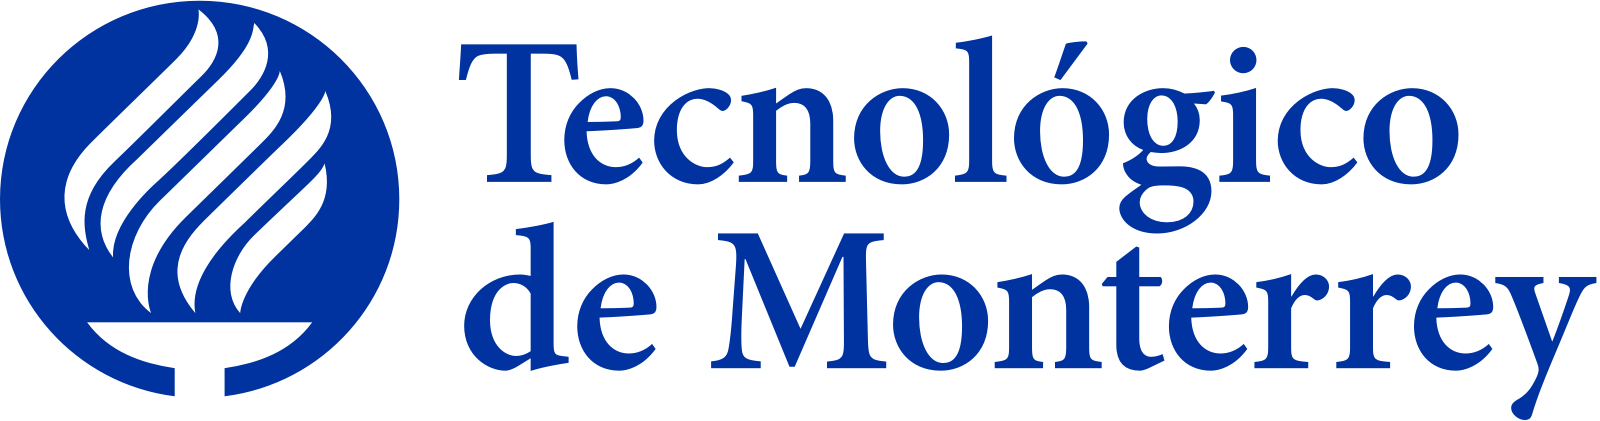

# **Master in Artificial Intelligence**

### Course: **Advanced Machine Learning Methods**

### Tecnológico de Monterrey

### Lead Professor José Antonio Cantoral Ceballos



## Team 38
*   A01794957 Tania Alicia Caballero Saavedra
*   A01283104 Kevin Dueñas Aguirre
*   A01794882 Francisco Marmolejo Martinez
*   A01795106 Francisco Javier Rupit Olvera
*   A01795093 Miguel Angel Alpizar Flores



## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [1]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
plt.style.use('ggplot')
from scipy.spatial.distance import cosine

#### Load file

In [2]:
from google.colab import drive #Here we connect to the collab drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
PATH = '/content/drive/MyDrive/Colab_Notebooks/ADV/act2/GLOVE/glove.6B.50d.txt' #We use our collab directory path for the Glove embedding for 50 dimensions
emb_dim = 50

In [20]:
def create_emb_dictionary(path):
    # Create an empty dictionary to store embeddings
    emb_dictionary = {}

    # Open the GloVe file and read line by line
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            # Split each line into word and its embedding
            values = line.split()
            word = values[0]  # the word
            embedding = np.array(values[1:], dtype=np.float32)  # the embedding as a numpy array

            # Add the word and its embedding to the dictionary
            emb_dictionary[word] = embedding

    return emb_dictionary

In [9]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

In [10]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [11]:
# Show some
def show_n_first_words(path, n_words): # Here we  take the file ro be read and get the number of words we want to show
        with open(path, 'r') as f: #Opens the file in read mode
            for i, line in enumerate(f): # We loop the reading of each line in the file
                print(line.split(), len(line.split()[1:])) # We split the lines read into words by the space and we count the words, then we print the list of words we counted
                if i>=n_words: break # If we exceed the number of words we stop the cycle

In [12]:
show_n_first_words(PATH, 5) #Here we show the first 5  words of the embedding file

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [21]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func = PCA):  # Extract the embeddings for the given words
  embeddings = np.zeros((len(words2show), emb_dim)) # Initialize an array to hold the embeddings for the words to show
  words2idx = {w:i for i, w in enumerate(words2show)}    # Create a dictionary to map each word to its index in the embeddings arra
  emb_dict = {}
  for word in words2show: # Loop over each word in the list of words to show
    idx = words2idx[word]  # Get the index of the word in the embeddings array
    embeddings[idx] = embeddings_dict[word] # Fill the embeddings array with the word's embedding from the dictionary
    reducer = func(n_components=2)  #Create a dimensionality reduction model (e.g., PCA) with 2 components
    embeddings_2d = reducer.fit_transform(embeddings) # Transform the high-dimensional embeddings to 2D for visualization

  plt.figure(figsize=(10, 10))
    # Initialize a plot with a specific figure size
  for i, word in enumerate(words2show): # Plot each word in the 2D space with its label
      x, y = embeddings_2d[i] # Get the 2D coordinates
      plt.scatter(x, y)  # Plot the point
      plt.text(x + 0.02, y + 0.02, word, fontsize=12) # Annotate the point with the word
# Label the axes and add a title and grid for clarity
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
  plt.title("2D Visualization of Word Embeddings")
  plt.grid(True)
  plt.show()  # Display the plot

In [17]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips', #these are the words to be plotted
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


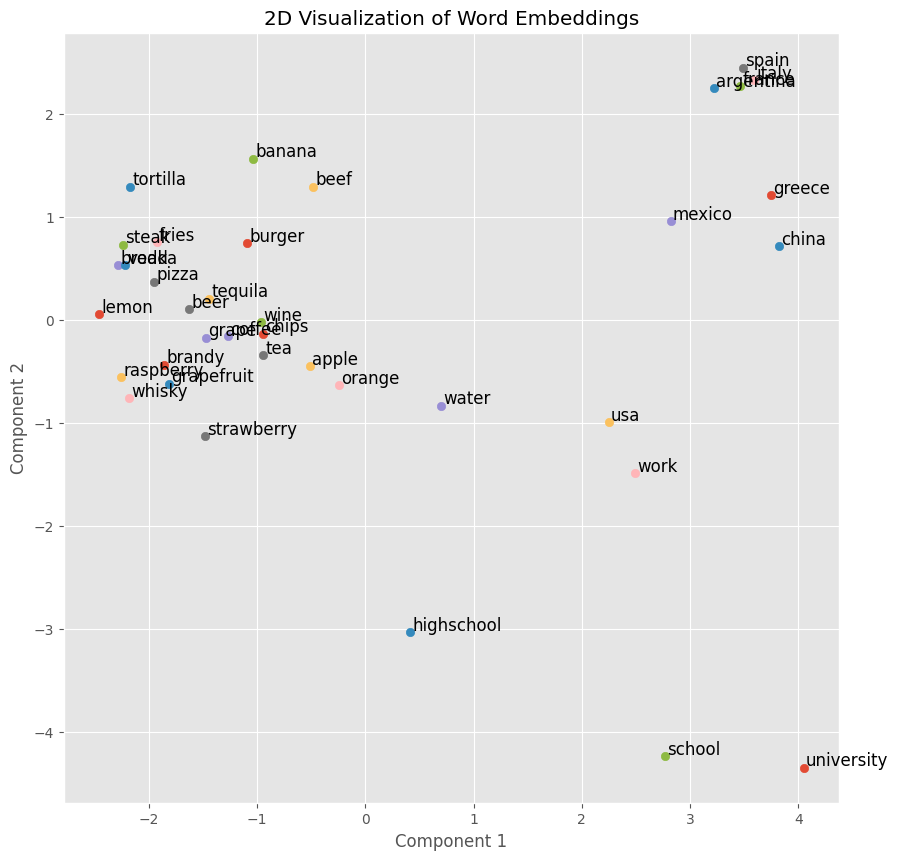

In [22]:

# PCA for dimensionality reduction
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

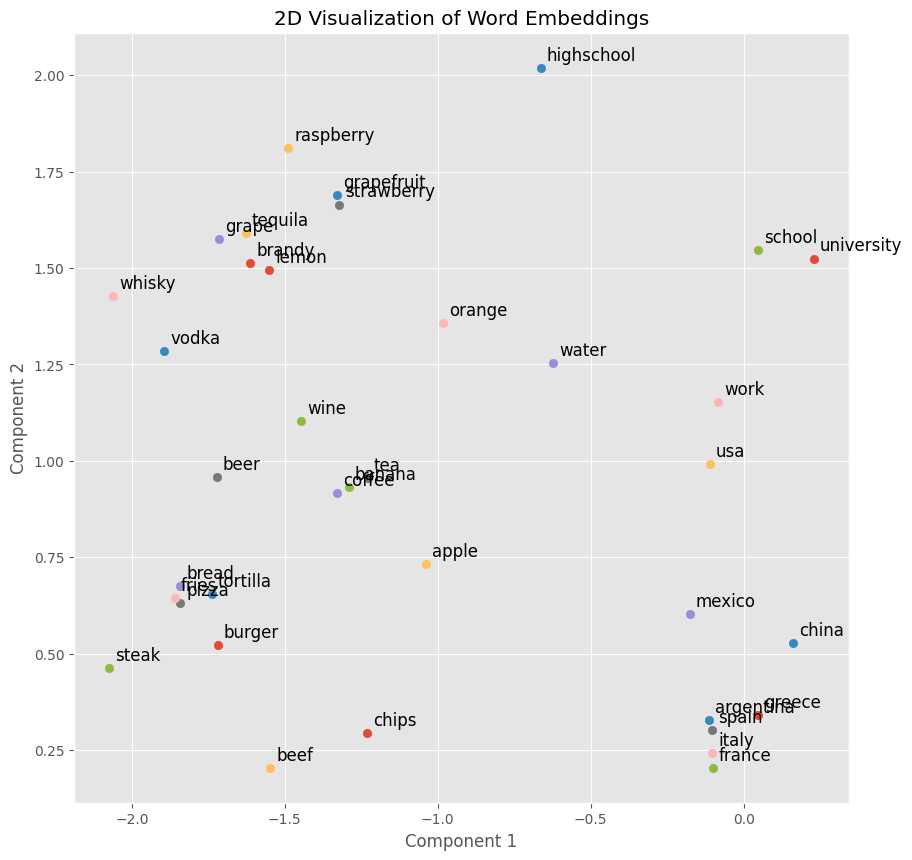

In [26]:
# t-SNE dimensionality reduction for visualization
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

In [27]:
# analogy
def analogy(word1, word2, word3, embeddings_dict, n=5): # here we will define the top n words that complete the analogy w1-w2+w3
   # Ensure that all words in the analogy exist in the embeddings dictionary
    if word1 not in embeddings_dict or word2 not in embeddings_dict or word3 not in embeddings_dict:
        raise ValueError(f"One or more words not in the embeddings dictionary: {word1}, {word2}, {word3}")
      # Retrieve the embeddings for the words involved in the analogy
    embedding_1 = embeddings_dict[word1]  # Word '1' embedding
    embedding_2 = embeddings_dict[word2]  # Word '2' embedding
    embedding_3 = embeddings_dict[word3]  # Word '3' embedding
    # Perform the analogy operation: a - b + c, resulting in a new vector
    result_embedding = embedding_1 - embedding_2 + embedding_3
    # Initialize a variable to store the closest word match
    closest_word = None
    closest_similarity = float('inf')  # Start with a very large value for comparison

    # Loop through the embeddings dictionary to find the closest word to the result embedding
    for word, embedding in embeddings_dict.items():
        # Skip the words that are part of the analogy (a, b, c)
        if word not in [word1, word2, word3]:
            # Calculate the cosine similarity between the result_embedding and the current word embedding
            similarity = cosine(result_embedding, embedding)
            # If the similarity is closer (lower cosine distance), update closest_word
            if similarity < closest_similarity:
                closest_similarity = similarity
                closest_word = word

    # Return the closest word that completes the analogy
    return closest_word


In [28]:
result = analogy('king', 'man', 'woman', embeddings_dict)
print(f"The result of 'king' - 'man' + 'woman' is: {result}")

The result of 'king' - 'man' + 'woman' is: queen


In [43]:
# most similar
def find_most_similar(word, embeddings_dict, top_n=10):
# Ensure the target word is in the embeddings dictionary
    if word not in embeddings_dict:
        raise ValueError(f"The word '{word}' is not in the embeddings dictionary.")

   # Get the vector for the target word and normalize it to unit length
    target_embedding = np.array(embeddings_dict[word])
    target_embedding=target_embedding/ np.linalg.norm(target_embedding) #

    # List to store the similarity scores
    similarities = []

       # Loop over each word and its embedding in the embeddings dictionary
    for other_word, embedding in embeddings_dict.items():
        # Skip the target word itself
        if other_word == word:
            continue

        # Normalize the vector for the other word
        other_vector = np.array(embedding)
        other_vector = other_vector / np.linalg.norm(other_vector)

        # Calculate the cosine similarity between the target and other word
        similarity = np.dot(target_embedding, other_vector)

        # Append the word and its similarity score to the list
        similarities.append((other_word, similarity))

    # Sort the list of similarities in descending order by similarity score
    similarities.sort(reverse=True, key=lambda x: x[1])

    # Return the top N most similar words
    return similarities[:top_n]


In [41]:
print(f"Sample embedding for 'king': {embeddings_dict.get('king')[:10]}")

Sample embedding for 'king': [ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012 ]


In [44]:
most_similar = find_most_similar('mexico', embeddings_dict) # Here we use the word Mexico as an example to find the most similar 10 words

In [45]:
for i, w in enumerate(most_similar, 1): #We loop the most similar words to be printed
    print(f'{i} ---> {w[0]}')

1 ---> mexican
2 ---> venezuela
3 ---> colombia
4 ---> peru
5 ---> chile
6 ---> puerto
7 ---> rico
8 ---> cuba
9 ---> guatemala
10 ---> panama
